# **Important Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D , Activation, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adamax,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import  EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# **Load & Prepare the Data**

In [2]:
# unzip the data
!unzip "/content/drive/MyDrive/Teeth DataSet.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Teeth_Dataset/Validation/CoS/b_111_0_6094.jpg  
  inflating: Teeth_Dataset/Testing/CoS/b_150_0_2905.jpg  
  inflating: Teeth_Dataset/Testing/OT/ot_1241_0_1157.jpg  
  inflating: Teeth_Dataset/Validation/CoS/b_95 - Copy_0_6372.jpg  
  inflating: Teeth_Dataset/Testing/CaS/a_152_0_7749.jpg  
  inflating: Teeth_Dataset/Testing/CaS/a_126_0_9339.jpg  
  inflating: Teeth_Dataset/Testing/outputs/a_110_0_9820.jpg  
  inflating: Teeth_Dataset/Testing/outputs/a_141_0_7620.jpg  
  inflating: Teeth_Dataset/Validation/CoS/b_132_0_2266.jpg  
  inflating: Teeth_Dataset/Testing/outputs/a_99_0_9803.jpg  
  inflating: Teeth_Dataset/Testing/OT/ot_1223_0_6812.jpg  
  inflating: Teeth_Dataset/Testing/OT/ot_1223_0_6082.jpg  
  inflating: Teeth_Dataset/Testing/output/a_145_0_219.jpg  
  inflating: Teeth_Dataset/Testing/output/a_119_0_1965.jpg  
  inflating: Teeth_Dataset/Testing/CoS/b_112_0_1990.jpg  
  inflating: Teeth_Dataset/Testing/output/a_1

In [3]:
!rm -rf "/content/Teeth_Dataset/Testing/outputs" "/content/Teeth_Dataset/Testing/output" "/content/Teeth_Dataset/Testing/out"

In [4]:
def create_dataset(data_dir):
  filepaths = []
  labels = []
  folds = os.listdir(data_dir)
  for fold in folds:
      foldpath = os.path.join(data_dir, fold)
      filelist = os.listdir(foldpath)
      for file in filelist:
          filepath = os.path.join(foldpath, file)
          filepaths.append(filepath)
          labels.append(fold)

  df = pd.DataFrame(data={'filepaths': filepaths, 'labels': labels})
  return df

In [5]:
train_data_dir = "/content/Teeth_Dataset/Training"
train = create_dataset(train_data_dir)
print(train.shape)
train.head()

(3087, 2)


,filepaths,labels
0,/content/Teeth_Dataset/Training/OT/ot_1213_0_9...,OT
1,/content/Teeth_Dataset/Training/OT/ot_1221_0_4...,OT
2,/content/Teeth_Dataset/Training/OT/ot_1217_0_2...,OT
3,/content/Teeth_Dataset/Training/OT/ot_1223_0_1...,OT
4,/content/Teeth_Dataset/Training/OT/ot_1262_0_9...,OT


In [6]:
test_data_dir = "/content/Teeth_Dataset/Testing"
test = create_dataset(test_data_dir)
print(test.shape)
test.head()

(1028, 2)


,filepaths,labels
0,/content/Teeth_Dataset/Testing/OT/ot_1210_0_63...,OT
1,/content/Teeth_Dataset/Testing/OT/ot_1252_0_89...,OT
2,/content/Teeth_Dataset/Testing/OT/ot_1214_0_31...,OT
3,/content/Teeth_Dataset/Testing/OT/ot_1258.jpg,OT
4,/content/Teeth_Dataset/Testing/OT/ot_1240_0_26...,OT


In [7]:
valid_data_dir = "/content/Teeth_Dataset/Validation"
valid = create_dataset(valid_data_dir)
print(valid.shape)
valid.head()

(1028, 2)


,filepaths,labels
0,/content/Teeth_Dataset/Validation/OT/ot_1227.jpg,OT
1,/content/Teeth_Dataset/Validation/OT/ot_1261_0...,OT
2,/content/Teeth_Dataset/Validation/OT/ot_1251_0...,OT
3,/content/Teeth_Dataset/Validation/OT/ot_1244.jpg,OT
4,/content/Teeth_Dataset/Validation/OT/ot_1211_0...,OT


In [8]:
# Class Distribution
def class_distribution(data,name):
  plt.figure(figsize=(7,7))
  ax = sns.countplot(data=data, x='labels')
  plt.title(f"Class Distribution of {name}")

  for p in ax.patches:
      ax.annotate(f'{int(p.get_height())}',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='baseline',
                  xytext=(0, 5),
                  textcoords='offset points')

  plt.show()

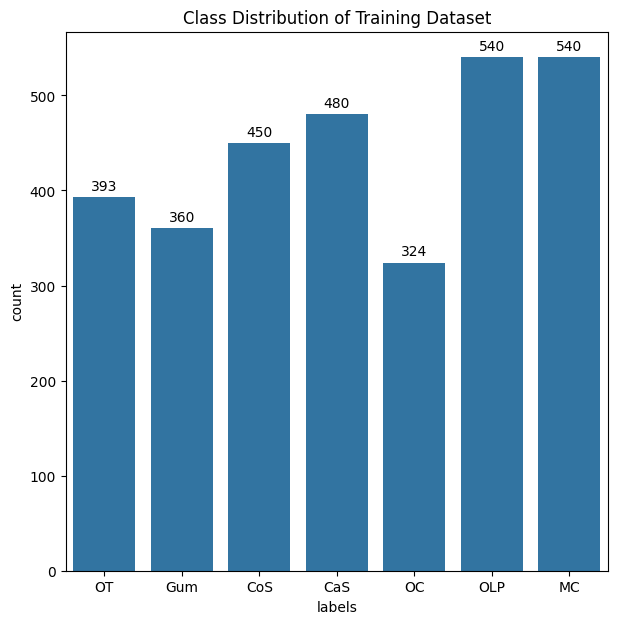

In [9]:
class_distribution(train,'Training Dataset')

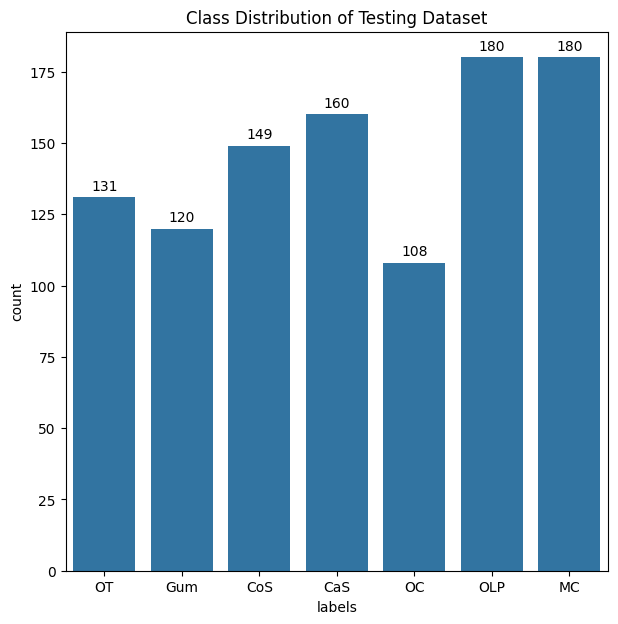

In [10]:
class_distribution(test,'Testing Dataset')

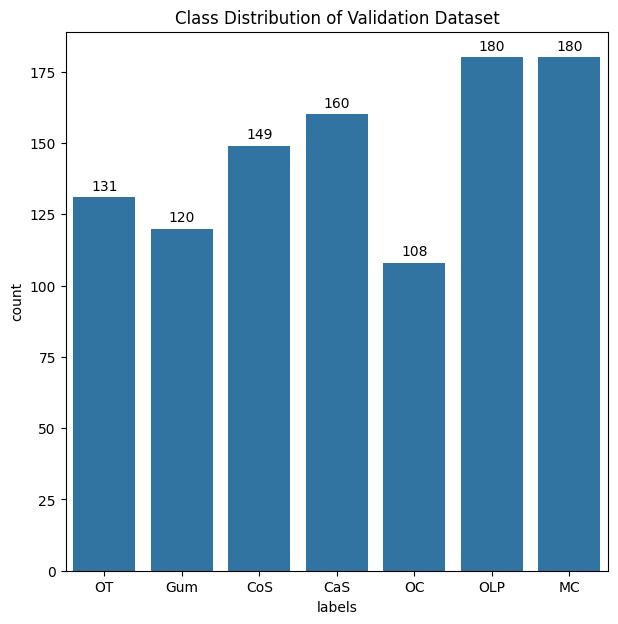

In [11]:
class_distribution(valid,'Validation Dataset')

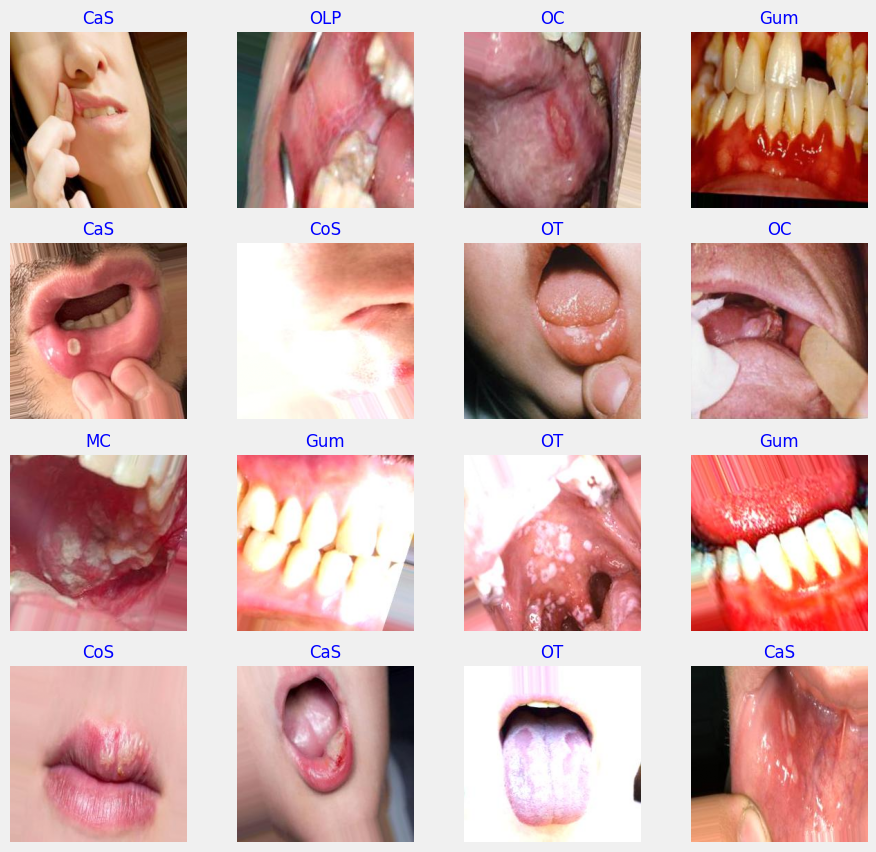

In [22]:
# Get samples from train data
classes = train['labels'].unique().tolist()
classes.sort()  # Sort for consistency

selected_rows = train.sample(n=16, random_state=42)

# Plot images
plt.figure(figsize=(10, 10))
for i, (_, row) in enumerate(selected_rows.iterrows()):
    plt.subplot(4, 4, i + 1)
    # Load and display image
    image = Image.open(row['filepaths'])
    image = np.array(image) / 255.0  # Normalize to [0, 1] as in your original code
    plt.imshow(image)
    # Get class name
    class_name = row['labels']
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

# **Image Data Generator**

In [13]:
batch_size = 32
img_size = (224, 224)

train_gen = ImageDataGenerator(rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.2])
test_gen = ImageDataGenerator()

train_gen = train_gen.flow_from_dataframe(
    train,
    x_col= 'filepaths',
    y_col= 'labels', target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle = True,
    batch_size= batch_size
)

valid_gen = test_gen.flow_from_dataframe(
    valid,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle = False,
    batch_size= batch_size
)

test_gen = test_gen.flow_from_dataframe(
    test,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle = False,
    batch_size= batch_size
)

Found 3087 validated image filenames belonging to 7 classes.
Found 1028 validated image filenames belonging to 7 classes.
Found 1028 validated image filenames belonging to 7 classes.


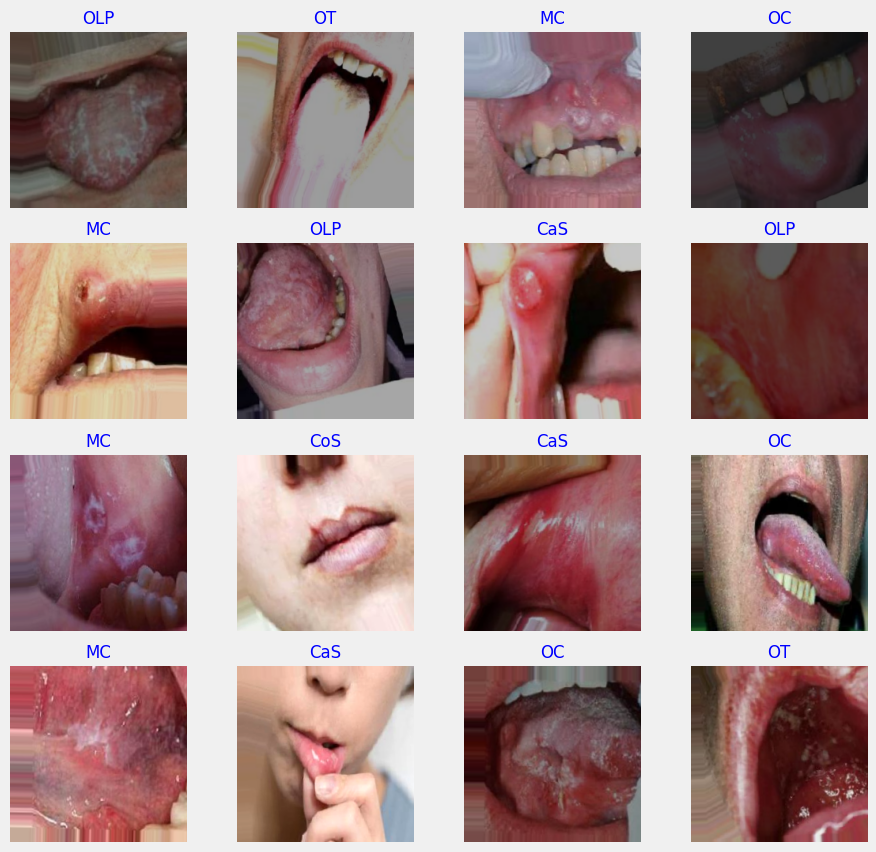

In [23]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model**

In [15]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,136,519 (214.14 MB)

 Trainable params: 56,134,599 (214.14 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [16]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.keras',
                                   monitor='val_accuracy',
                                   save_best_only=True)

history=model.fit(train_gen,epochs=50,
                  batch_size = batch_size,
                  validation_data=valid_gen,
                  callbacks=[early_stopping,model_checkpoint])

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.2051 - loss: 3.9086 - val_accuracy: 0.2471 - val_loss: 1.9291
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 650ms/step - accuracy: 0.2615 - loss: 2.1012 - val_accuracy: 0.2811 - val_loss: 2.1147
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 61s 628ms/step - accuracy: 0.3057 - loss: 1.8828 - val_accuracy: 0.3502 - val_loss: 1.7938
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 62s 634ms/step - accuracy: 0.3570 - loss: 1.7058 - val_accuracy: 0.4591 - val_loss: 1.4827
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 62s 641ms/step - accuracy: 0.3758 - loss: 1.6522 - val_accuracy: 0.4728 - val_loss: 1.3925
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 63s 643ms/step - accuracy: 0.4268 - loss: 1.5108 - val_accuracy: 0.5516 - val_loss: 1.2619
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 61s 627ms/step - accuracy: 0.4752 - loss: 1.4111 - val_accuracy: 0.5535 - val_loss: 1.2472
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 78s 583ms/step - accuracy: 0.4625 - loss: 1.4203 - val_accura

# **Evaluate the Model**

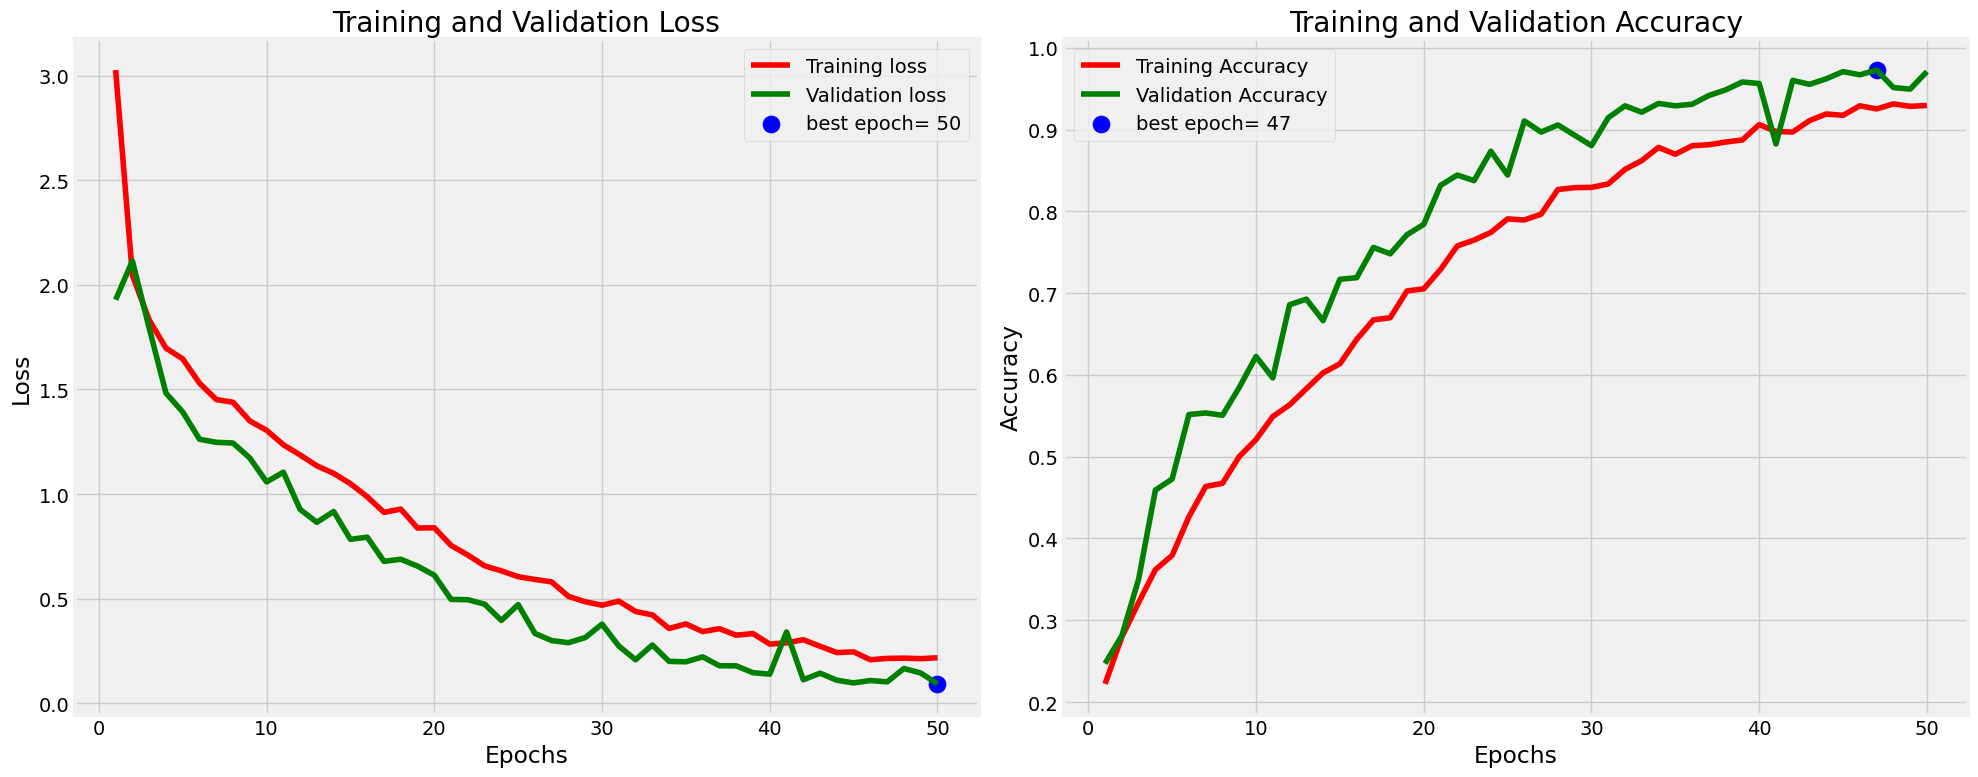

In [17]:
# Plot Accuracy and Loss
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 554ms/step - accuracy: 0.9829 - loss: 0.0685
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9873 - loss: 0.0660
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9700 - loss: 0.0791
Train Loss:  0.07185041904449463
Train Accuracy:  0.9815354943275452
--------------------
Validation Loss:  0.10169611126184464
Validation Accuracy:  0.9727626442909241
--------------------
Test Loss:  0.10515628010034561
Test Accuracy:  0.9640077948570251


In [19]:
# Get Predictions
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step


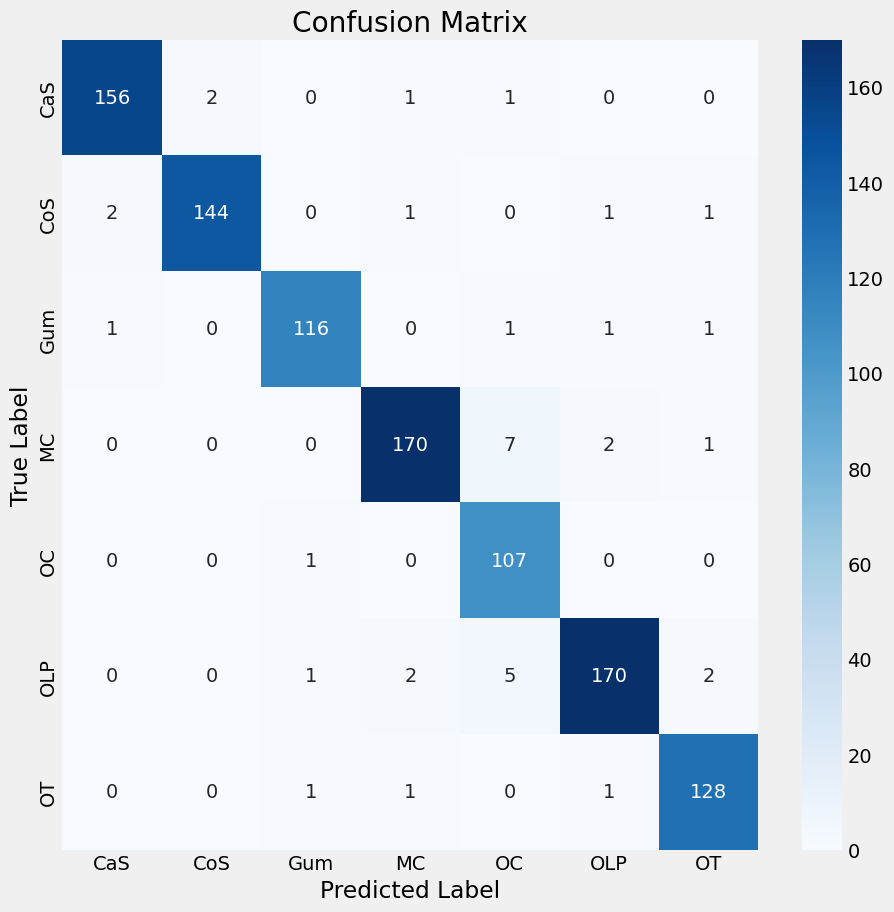

In [20]:
# Confusion Matrix
plt.figure(figsize=(10, 10))
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [21]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         CaS       0.98      0.97      0.98       160
         CoS       0.99      0.97      0.98       149
         Gum       0.97      0.97      0.97       120
          MC       0.97      0.94      0.96       180
          OC       0.88      0.99      0.93       108
         OLP       0.97      0.94      0.96       180
          OT       0.96      0.98      0.97       131

    accuracy                           0.96      1028
   macro avg       0.96      0.97      0.96      1028
weighted avg       0.97      0.96      0.96      1028

